In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">2º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº 49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# 1 - Introdução




# 2 - Desenvolvimento


## 2.1 - Transformação de dados com TF-IDF

limpeza dos textos (HTML, regex, min_df, etc.),

seleção de parâmetros do TfidfVectorizer (ex.: min_df, max_df, ngram_range, token_pattern, stop_words, norm, etc.),

evitar vocabulários demasiado grandes (afetam desempenho e overfitting).


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

# carregar dados
D = pickle.load(open("imdbFull.p", "rb"))
data = D["data"]
data = data[0:10000] # TODO: Remove this when pickling the final data
labels = D["target"]
lancaster = LancasterStemmer()

def clean_text(t):
    t = t.replace("<br />", " ")                  
    t = re.sub(r"[^a-zA-Z]+", " ", t)             
    t = t.lower()
    return t

def apply_stemming(text, stemmer):
    return " ".join(stemmer.stem(word) for word in text.split())


def vectorize_data(data, stemmer, use_pickled=False):
    fname = "vectorized.pkl"
    
    if(use_pickled == True):
        f = open(fname, 'rb')
        return pickle.load(fname)
    
    X_clean = []
    for t in data:
        cleaned = clean_text(t)
        cleaned = apply_stemming(cleaned, stemmer)
        X_clean.append(cleaned)

    vectorizer = TfidfVectorizer(
        min_df=5,                       
        stop_words="english",           
        token_pattern=r"[a-zA-Z]{3,}",  
        ngram_range=(1,2)
    )

    
    if(use_pickled == False):
        f = open(fname, 'wb')
        pickle.dump(vectorizer, f)
    
    return X_clean, vectorizer

# TODO: The test train split needs to be done BEFORE the transform. the transform is for each one
X_clean, vectorizer = vectorize_data(data, lancaster, use_pickled=False)
X_transformed = vectorizer.fit_transform(X_clean)

## 2.2 - Treino de Classificadores 
- train/test split com estratificação,
- k-fold cross validation, StratifiedKFold,

- análise de métricas: matriz de confusão, recall, precision.



In [ ]:
# regressor linear com test train split e idf
# exemplo feito durante a aula só para referencia para a malta. Usar o vectorizer de cima
"""
X_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)

# fit no train
idf = TfidfVectorizer(min_df=5).fit(X_train)

# transform train e test
X_train_idf = idf.transform(X_train)
X_test_idf = idf.transform(X_test)

# regressor linear
lr = LogisticRegression(max_iter=1000)

# fit
lr.fit(X_train_idf, y_train)

# predict
lr.predict(X_test_idf)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)\n\n# fit no train\nidf = TfidfVectorizer(min_df=5).fit(X_train)\n\n# transform train e test\nX_train_idf = idf.transform(X_train)\nX_test_idf = idf.transform(X_test)\n\n# regressor linear\nlr = LogisticRegression(max_iter=1000)\n\n# fit\nlr.fit(X_train_idf, y_train)\n\n# predict\nlr.predict(X_test_idf)\n'

### 2.2.1 - Classificação multi-classe

Treinar um modelo que recebe o texto da crítica e prevê a pontuação exata (1–4 ou 7–10 → total de 8 classes).
- Escolhes um ou mais modelos adequados (com base nos slides):
- Exemplos de classificadores
- Logistic Regression,
- SVM,
- Linear Regression,
- Lasso Regression

Depois:
-  comparar classificadores e regressões,
- converter previsões da regressão em classes,
- analisar qual abordagem funciona melhor.

### 2.2.2 - Análise com Regressão Linear

Treinar um modelo para prever a pontuação contínua da crítica. Depois, converter as previsões contínuas do regressor para rótulos de classificação:

valores preditos → mapeados para 1–4 e 7–10.


### 2.2.3 - Análise dos resultados

- desempenho da classificação direta,
- desempenho da classificação derivada da regressão.
Para regressão, medir:
- MAE
- MSE

## 2.3 - Clustering

1. Aplicar K-Means como método base de clustering.
2. Aplicar um segundo método (AgglomerativeClustering) para comparação.
3. Avaliar e comparar os métodos considerando:
    - separação dos clusters (silhouette)
    - distância entre centróides
    - palavras representativas
    - consistência visual (PCA)
    - distribuição dos clusters
4. Investigar o impacto da variação de k no desempenho e interpretação dos clusters.
5. Escolher o método e valor de k mais adequado com base nas métricas.


In [49]:
import numpy as np
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def top_words_per_cluster(centers, feature_names, n=15):
    for i, c in enumerate(centers):
        print(f"\nCluster {i}:")
        idx = np.argsort(c)[::-1][:n]
        print(", ".join(feature_names[j] for j in idx))


def show_examples_per_cluster(data, labels, n=3):
    for c in np.unique(labels):
        print(f"\n===== Cluster {c} =====")
        idx = np.where(labels == c)[0][:n]
        for i in idx:
            print(data[i][:300], "\n---")


def plot_clusters_2D(X, labels, title="Clusters"):
    # reduzir amostra
    X_sample = X.toarray()
    labels_sample = labels

    pca = PCA(n_components=2, random_state=42)
    X_2D = pca.fit_transform(X_sample)

    plt.figure(figsize=(10,7))
    plt.scatter(X_2D[:,0], X_2D[:,1], c=labels_sample, cmap="tab10", s=10)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

    return pca, X_2D

KMeans (k=5)
Inertia: 80.99736896122754
Silhouette Score: 0.0029123094322615756


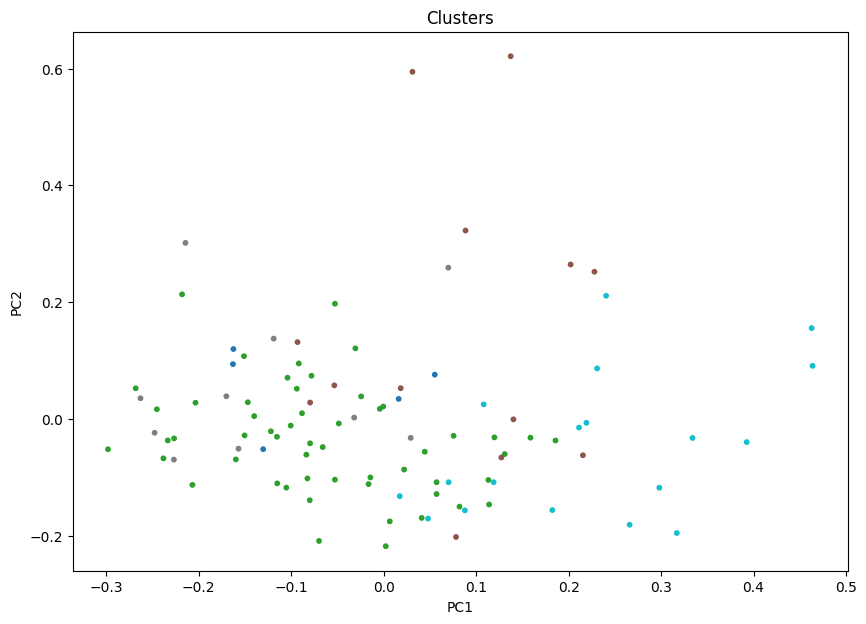

(PCA(n_components=2, random_state=42),
 array([[-5.33595241e-02,  5.74249827e-02],
        [ 2.27946433e-01,  2.52078384e-01],
        [ 3.17025964e-01, -1.95551467e-01],
        [ 1.08178477e-01,  2.48531509e-02],
        [ 4.44560923e-02, -5.62638071e-02],
        [-4.55450536e-04,  2.11957795e-02],
        [ 4.10884497e-02, -1.69669445e-01],
        [-9.31659024e-02,  1.31529421e-01],
        [-1.15116970e-01, -1.10484022e-01],
        [-6.98727395e-02, -2.09101242e-01],
        [-9.39492218e-02,  5.16820755e-02],
        [ 2.15481446e-01, -6.23196457e-02],
        [ 7.56303828e-02, -2.89698451e-02],
        [-1.59832829e-01, -6.94527367e-02],
        [ 6.99230224e-02,  2.59045445e-01],
        [-1.50362562e-01, -2.83428631e-02],
        [ 8.78387647e-02, -1.56747962e-01],
        [-8.82865707e-02,  9.67897975e-03],
        [ 4.63804483e-01,  9.08409469e-02],
        [ 2.27005154e-03, -2.18151308e-01],
        [-2.45239029e-01,  1.65480701e-02],
        [-2.26637471e-01, -3.35052885

In [74]:
from sklearn.cluster import KMeans
import numpy as np

# número de clusters a testar (ex.: 5)
k = 5 # TODO: Testar vários K

def kmeans_cluster(k, X):
    print(f"KMeans (k={k})")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=500,
        random_state=42
    )

    kmeans.fit(X)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    inertia = kmeans.inertia_
    sil = silhouette_score(X, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil

labels,centers,inertia,sil = kmeans_cluster(5,X_transformed)


plot_clusters_2D(X_transformed, labels)



In [ ]:
from sklearn.cluster import AgglomerativeClustering


def agg_cluster(k, X):
    print(f"AgglomerativeClustering (k={k})")

    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
    )

    labels = agg.fit_predict(X.toarray())  # hierárquico precisa array

    sil = silhouette_score(X, labels)
    print("Silhouette Score:", sil)


    # Calcular centro de cada cluster
    centers = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        centers.append(X[idx].mean(axis=0))

    centers = np.array(centers).squeeze()

    return labels, centers, sil
    
agg_cluster(10,X_transformed)


AgglomerativeClustering (k=10)
Silhouette Score: 0.012082947987404915
[5 0 3 0 3 1 8 2 4 6 4 0 1 1 4 6 3 5 7 8 2 2 2 1 0 0 4 2 6 1 5 2 0 0 3 6 0
 3 2 2 2 8 7 2 0 3 4 6 2 8 4 8 1 2 6 0 1 6 3 7 0 2 4 0 1 7 8 5 1 0 2 0 9 9
 0 1 7 7 3 2 5 2 7 6 2 1 3 0 5 2 6 0 2 2 5 6 5 1 1 7]


(array([5, 0, 3, 0, 3, 1, 8, 2, 4, 6, 4, 0, 1, 1, 4, 6, 3, 5, 7, 8, 2, 2,
        2, 1, 0, 0, 4, 2, 6, 1, 5, 2, 0, 0, 3, 6, 0, 3, 2, 2, 2, 8, 7, 2,
        0, 3, 4, 6, 2, 8, 4, 8, 1, 2, 6, 0, 1, 6, 3, 7, 0, 2, 4, 0, 1, 7,
        8, 5, 1, 0, 2, 0, 9, 9, 0, 1, 7, 7, 3, 2, 5, 2, 7, 6, 2, 1, 3, 0,
        5, 2, 6, 0, 2, 2, 5, 6, 5, 1, 1, 7]),
 array([[0.        , 0.        , 0.02854414, ..., 0.        , 0.00961968,
         0.02537341],
        [0.00959124, 0.01526145, 0.        , ..., 0.0157773 , 0.        ,
         0.        ],
        [0.01177152, 0.        , 0.00426203, ..., 0.00263613, 0.0204073 ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.0146306 ],
        [0.015992  , 0.01989202, 0.        , ..., 0.04311881, 0.01670204,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], shape=(10, 466)),
 0.012082947987404915)

In [ ]:
import collections
print(collections.Counter(labels))

"""
for i in range(k):
    print(f"\nCluster {i} exemplo:\n")
    idx = np.where(labels == i)[0][:3]
    for j in idx:
        print(data[j][:400], "\n---")
"""

def compare_methods(sil_kmeans, sil_hier):
    print("\n### Comparação entre métodos ###\n")
    print("Silhouette K-Means:", sil_kmeans)
    print("Silhouette Hierárquico:", sil_hier)

    if sil_kmeans > sil_hier:
        print("\n➡ K-Means apresenta melhor separação de clusters.")
    else:
        print("\n➡ Clustering Hierárquico apresenta melhor separação de clusters.")



Counter({np.int32(1): 54, np.int32(4): 18, np.int32(2): 13, np.int32(3): 10, np.int32(0): 5})


'\nfor i in range(k):\n    print(f"\nCluster {i} exemplo:\n")\n    idx = np.where(labels == i)[0][:3]\n    for j in idx:\n        print(data[j][:400], "\n---")\n'

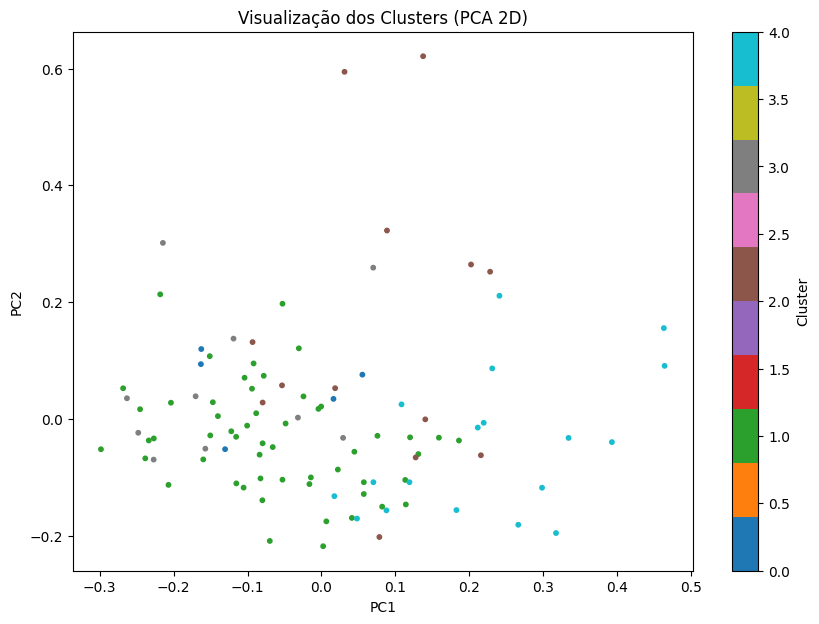

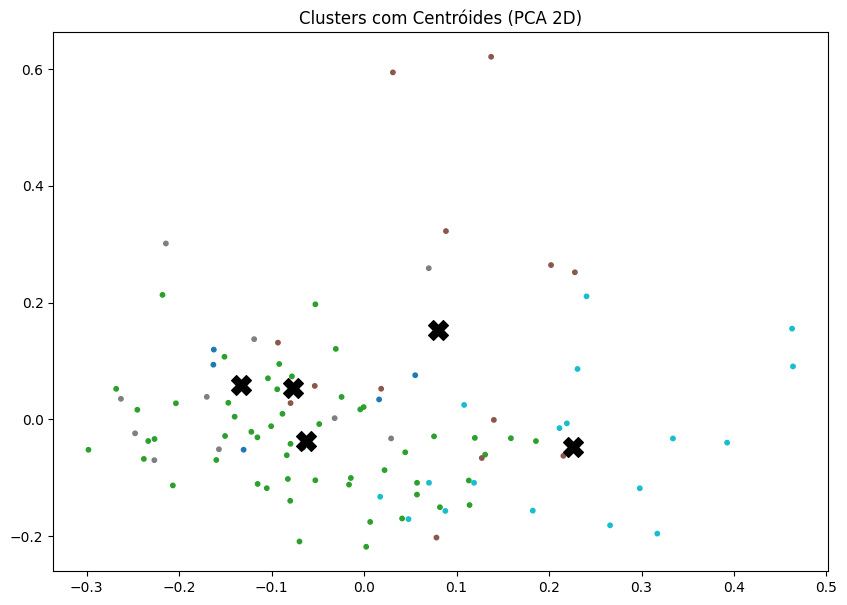

In [40]:
# Plotar Clusters em 2D


from sklearn.decomposition import PCA

X_sample = X_transformed.toarray()
pca = PCA(n_components=2, random_state=42)
X_2D = pca.fit_transform(X_sample)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

scatter = plt.scatter(
    X_2D[:, 0],
    X_2D[:, 1],
    c=labels[:len(X_2D)],   # garantir o mesmo tamanho
    cmap="tab10",
    s=10
)

plt.title("Visualização dos Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()

centers_2D = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,7))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels[:len(X_2D)], cmap="tab10", s=10)
plt.scatter(centers_2D[:,0], centers_2D[:,1], c="black", s=200, marker="X")
plt.title("Clusters com Centróides (PCA 2D)")
plt.show()



In [70]:
def evaluate_k_values(X, k_list):
    sil_scores = []
    
    for k in k_list:
        print(f"\n=== Avaliando k = {k} ===")
        labels, centers, inertia, sil = kmeans_cluster(k, X)
        sil_scores.append((k, sil))

    print("\n\n### Silhouette por k ###")
    for k, sil in sil_scores:
        print(f"k={k}: silhouette={sil}")

    return sil_scores

k_list = [5, 8, 10, 20]

evaluate_k_values(X_transformed, [5, 8, 10, 20])


=== Avaliando k = 5 ===
KMeans (k=5)
Inertia: 80.99736896122754
Silhouette Score: 0.0029123094322615756

=== Avaliando k = 8 ===
KMeans (k=8)
Inertia: 77.14967566215033
Silhouette Score: 0.008586503684348427

=== Avaliando k = 10 ===
KMeans (k=10)
Inertia: 75.5581884779022
Silhouette Score: 0.0022315736759854145

=== Avaliando k = 20 ===
KMeans (k=20)
Inertia: 64.80652886115851
Silhouette Score: 0.008257681571223962


### Silhouette por k ###
k=5: silhouette=0.0029123094322615756
k=8: silhouette=0.008586503684348427
k=10: silhouette=0.0022315736759854145
k=20: silhouette=0.008257681571223962


[(5, 0.0029123094322615756),
 (8, 0.008586503684348427),
 (10, 0.0022315736759854145),
 (20, 0.008257681571223962)]

# 3 - Conclusões

# 4 - Bibliografia

- https://mariofilho.com/precisao-recall-e-f1-score-em-machine-learning/ 
- https://studyeasy.org/pt/course-articles/machine-leaning-articles-pt/auc-and-pr-curve-background-pt/#binary-classification-a-primer
- https://www.geeksforgeeks.org/machine-learning/how-to-choose-the-best-kernel-function-for-svms/
- https://stats.stackexchange.com/questions/279911/why-is-svm-sensitive-to-scaling-of-features